# Action Detection

## Set up enviornment

In [0]:
!pip3 install torch torchvision

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import numpy as np
import scipy
from scipy.io import loadmat
from random import shuffle
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [0]:
os.chdir('drive/Colab_Notebooks/c3d/')

## Data Loader

In [0]:
video_rootdir="./ReCompress_Videos"
mask_rootdir="./puppet_mask"
pose_rootdir="./joint_positions"

video_pathes=[]
mask_pathes=[]
pose_pathes=[]
for root, dirs, files in os.walk(video_rootdir):
    for file in files:
        video_pathes.append(os.path.join(root, file))

for root, dirs, files in os.walk(mask_rootdir):
    for file in files:
        mask_pathes.append(os.path.join(root, file)) 

for root, dirs, files in os.walk(pose_rootdir):
    for file in files:
        pose_pathes.append(os.path.join(root, file))
        
video_pathes = sorted(video_pathes)
mask_pathes = sorted(mask_pathes)
pose_pathes = sorted(pose_pathes)

In [0]:
video_pathes_train, video_pathes_valid, mask_pathes_train, mask_pathes_valid, pose_pathes_train, pose_pathes_valid = train_test_split(video_pathes, mask_pathes, pose_pathes, test_size=0.3)
class_names=[name for name in os.listdir(video_rootdir)]
class_num=len(class_names)

In [0]:
class JHMDB(torch.utils.data.Dataset):
    def __init__(self, video_pathes, mask_pathes, pose_pathes, class_names, add_mask = True, F = 15):
        
        self.data = {'video': [], 'label': [], 'mask':[], 'pose':[], 'scale':[]}
        self.add_mask = add_mask
        self.classdict = {}
        for i, x in enumerate(class_names):
            self.classdict[x] = i

        video_num=len(video_pathes)
        mask_num=len(mask_pathes)

        for i in range(video_num):
            video=[]
            cap = cv2.VideoCapture(video_pathes[i])
            has_frame=True
            while(has_frame):
                _, frame = cap.read()
                has_frame = frame is not None

                if has_frame:
                    frame = cv2.resize(frame, (112, 112), interpolation = cv2.INTER_CUBIC)
                    video.append(frame)
            cap.release()
                    
            self.data['video'].append(video)

            mask_mat = loadmat(mask_pathes[i]) 
            masks = cv2.resize(mask_mat['part_mask'], (112, 112), interpolation = cv2.INTER_CUBIC) # (112, 112, F)
            self.data['mask'].append(masks)
            
            self.data['label'].append(video_pathes[i].split('/')[-2])
            
            pose_mat = loadmat(pose_pathes[i])['pos_img']
            scale = loadmat(pose_pathes[i])['scale']
            self.data['pose'].append(pose_mat)
            self.data['scale'].append(scale[0]) # redundant dim
    
    def _compute_mean(self):
        meanstd_file = './data/jhmdbmean'
        if os.path.isfile(meanstd_file):
            meanstd = torch.load(meanstd_file)
        else:
            mean = torch.zeros(3)
            std = torch.zeros(3)
            for videos in self.data['video']:
                for img in videos:
                    # CxHxW
                    mean += np.reshape(img, (img.shape(0), -1)).mean(1)
                    std += np.reshape(img, (img.shape(0), -1)).std(1)
            mean /= len(self.train)
            std /= len(self.train)
            meanstd = {
                'mean': mean,
                'std': std,
                }
            torch.save(meanstd, meanstd_file)
            
        print('    Mean: %.4f, %.4f, %.4f' % (meanstd['mean'][0], meanstd['mean'][1], meanstd['mean'][2]))
        print('    Std:  %.4f, %.4f, %.4f' % (meanstd['std'][0], meanstd['std'][1], meanstd['std'][2]))

        return meanstd['mean'], meanstd['std']
        
    def __getitem__(self, index):
        # video (C, F, 112, 112)
        # mask (112, 112, F)
        # pose (2, 15, F)
        # scale (F)
        # label (1), 
        # randomly select 15 consecutive frames (F = 15)
        F = 15
        frame_num = self.data['mask'][index].shape[2]
        frame_shuffle=list(range(frame_num))
        shuffle(frame_shuffle)
        selected_frame=sorted(frame_shuffle[0:F])
       
        # change pose position according to resize
        pose_data = torch.from_numpy(self.data['pose'][index][:,:,selected_frame].astype('float'))
        pose_data[0,:,:] = pose_data[0,:,:] * 112 / 320
        pose_data[1,:,:] = pose_data[1,:,:] * 112 / 240
        
        if self.add_mask == True:
            m = (self.data['mask'][index][:,:,selected_frame] + 1) / 2
            m = np.expand_dims(np.transpose(m, (2, 0, 1)), axis=3)
            v = np.array(self.data['video'][index])[selected_frame,:,:,:]
            v = np.multiply(m,v)
            
        video = np.transpose(v, (3, 0, 1, 2))
        return torch.FloatTensor(video), \
            torch.from_numpy(self.data['mask'][index][:,:,selected_frame].astype('float')), \
            pose_data, \
            torch.from_numpy(self.data['scale'][index][selected_frame].astype('float')), \
            torch.LongTensor([self.classdict[self.data['label'][index]]])
        
    def __len__(self):
        return len(self.data['scale'])

In [0]:
train_dataset = JHMDB(video_pathes_train, mask_pathes_train, pose_pathes_train, class_names)
valid_dataset = JHMDB(video_pathes_valid, mask_pathes_valid, pose_pathes_valid, class_names)

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=10, shuffle=False)

## Model

N \* 3 \* 15 \* 112 \* 112 --> N \* 64 \* 15 \* 56 \* 56 -->  N \* 128 \* 8 \* 28 \* 28 --> N \* 256 \* 4 \* 14 \* 14 --> N \* 512 \* 2 \* 7 \* 7 --> N \* 512 \* 1 \* 4 \* 4

In [0]:
class C3D(nn.Module):
    """
    The C3D network as described in [1].
    """

    def __init__(self,class_num):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(1, 0, 0))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, class_num)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):

        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        h = self.dropout(h)

        logits = self.fc8(h)

        return logits

## Train

In [0]:
def eval_video(net,test_video,test_label):
    net.eval()
    _, indices=torch.max(net(test_video),1)
    correct_prediction=torch.eq(indices,test_label.squeeze(1)).data.sum()
    return correct_prediction.cpu().numpy()

In [10]:
criterion = nn.CrossEntropyLoss().cuda()
net=C3D(class_num).cuda()

#Initialize from pre-trained model
pretrained_dict = torch.load('./c3d.pickle')
pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith( 'fc8' )}
model_dict=net.state_dict()
model_dict.update(pretrained_dict) 
net.load_state_dict(model_dict)

print(net)

init_lr=0.001
def exp_lr_scheduler(optimizer, epoch, init_lr=init_lr, lr_decay_epoch=10):
    """Decay learning rate by a factor of 2 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

optimizer = torch.optim.SGD(net.parameters(), init_lr)

C3D(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(1, 0, 0), dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3),

In [0]:
def train(epoch,step,log):
    net.train()
    train_loss = 0
    step_cnt = 0
    
    for index,x in enumerate(train_loader):
        train_video=Variable(x[0]).cuda() 
        train_video_label=Variable(x[4]).cuda()
        train_result=net(train_video)
        
        # forward
        loss = criterion(train_result,train_video_label.squeeze(1))
        train_loss += loss.data[0]
        step_cnt += train_video_label.shape[0]
        step += train_video_label.shape[0]
        # backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log to screen        
        log_text = 'epoch %d, step %d, loss: %.4f' % (epoch, step, train_loss / step_cnt)
        print(log_text)
        log['loss_step'].append(step)
        log['loss'].append(train_loss / step_cnt)
        train_loss = 0
        step_cnt = 0
        
        
        
    # Evaluate the model
    net.eval()
    test_size=0
    correct_num=0
    for y in valid_loader:
        test_video=Variable(y[0]).cuda()
        test_video_label=Variable(y[4]).cuda()
        test_size += test_video_label.shape[0]
        correct_num += eval_video(net,test_video,test_video_label)
    accuracy = correct_num/test_size*100 
    print(accuracy)
    log['accuracy_step'].append(step)
    log['accuracy'].append(accuracy)
    net.train()
        
    return step

In [12]:
step=0
log = {'loss_step': [], 'loss': [], 'accuracy_step':[], 'accuracy':[]}
for epoch in range(20):
    step = train(epoch,step,log)
    exp_lr_scheduler(optimizer, epoch, init_lr, lr_decay_epoch=10)
torch.save(net.state_dict(), "./c3d_with_attention.pickle")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


epoch 0, step 10, loss: 0.2990
epoch 0, step 20, loss: 0.3101
epoch 0, step 30, loss: 0.3266
epoch 0, step 40, loss: 0.3168
epoch 0, step 50, loss: 0.2883
epoch 0, step 60, loss: 0.3036
epoch 0, step 70, loss: 0.2896
epoch 0, step 80, loss: 0.2888
epoch 0, step 90, loss: 0.3046
epoch 0, step 100, loss: 0.3154
epoch 0, step 110, loss: 0.3085
epoch 0, step 120, loss: 0.3069
epoch 0, step 130, loss: 0.2976
epoch 0, step 140, loss: 0.3014
epoch 0, step 150, loss: 0.2963
epoch 0, step 160, loss: 0.2929
epoch 0, step 170, loss: 0.3209
epoch 0, step 180, loss: 0.3018
epoch 0, step 190, loss: 0.3034
epoch 0, step 200, loss: 0.2795
epoch 0, step 210, loss: 0.2790
epoch 0, step 220, loss: 0.2891
epoch 0, step 230, loss: 0.2671
epoch 0, step 240, loss: 0.3108
epoch 0, step 250, loss: 0.2851
epoch 0, step 260, loss: 0.2488
epoch 0, step 270, loss: 0.2486
epoch 0, step 280, loss: 0.2807
epoch 0, step 290, loss: 0.2665
epoch 0, step 300, loss: 0.2893
epoch 0, step 310, loss: 0.2550
epoch 0, step 320

epoch 1, step 779, loss: 0.1890
epoch 1, step 789, loss: 0.2152
epoch 1, step 799, loss: 0.1945
epoch 1, step 809, loss: 0.1109
epoch 1, step 819, loss: 0.1346
epoch 1, step 829, loss: 0.1574
epoch 1, step 839, loss: 0.1933
epoch 1, step 849, loss: 0.1539
epoch 1, step 859, loss: 0.1739
epoch 1, step 869, loss: 0.1070
epoch 1, step 879, loss: 0.1957
epoch 1, step 889, loss: 0.2007
epoch 1, step 899, loss: 0.1857
epoch 1, step 909, loss: 0.1921
epoch 1, step 919, loss: 0.1248
epoch 1, step 929, loss: 0.1140
epoch 1, step 939, loss: 0.1312
epoch 1, step 949, loss: 0.1558
epoch 1, step 959, loss: 0.1494
epoch 1, step 969, loss: 0.1202
epoch 1, step 979, loss: 0.1255
epoch 1, step 989, loss: 0.0999
epoch 1, step 999, loss: 0.1562
epoch 1, step 1009, loss: 0.0552
epoch 1, step 1019, loss: 0.1243
epoch 1, step 1029, loss: 0.1057
epoch 1, step 1039, loss: 0.0864
epoch 1, step 1049, loss: 0.1080
epoch 1, step 1059, loss: 0.1623
epoch 1, step 1069, loss: 0.1238
epoch 1, step 1079, loss: 0.1796


epoch 2, step 1548, loss: 0.0514
epoch 2, step 1558, loss: 0.0504
epoch 2, step 1568, loss: 0.1101
epoch 2, step 1578, loss: 0.1766
epoch 2, step 1588, loss: 0.0819
epoch 2, step 1598, loss: 0.0926
epoch 2, step 1608, loss: 0.1727
epoch 2, step 1618, loss: 0.0918
epoch 2, step 1628, loss: 0.0183
epoch 2, step 1638, loss: 0.1074
epoch 2, step 1648, loss: 0.0489
epoch 2, step 1658, loss: 0.1491
epoch 2, step 1668, loss: 0.0566
epoch 2, step 1678, loss: 0.0508
epoch 2, step 1688, loss: 0.0627
epoch 2, step 1698, loss: 0.0789
epoch 2, step 1708, loss: 0.1230
epoch 2, step 1718, loss: 0.1522
epoch 2, step 1728, loss: 0.0773
epoch 2, step 1738, loss: 0.0966
epoch 2, step 1748, loss: 0.0833
epoch 2, step 1758, loss: 0.1294
epoch 2, step 1768, loss: 0.1089
epoch 2, step 1778, loss: 0.1637
epoch 2, step 1788, loss: 0.0898
epoch 2, step 1798, loss: 0.0679
epoch 2, step 1808, loss: 0.0517
epoch 2, step 1818, loss: 0.1401
epoch 2, step 1828, loss: 0.0708
epoch 2, step 1838, loss: 0.0922
epoch 2, s

epoch 3, step 2307, loss: 0.0433
epoch 3, step 2317, loss: 0.0674
epoch 3, step 2327, loss: 0.0643
epoch 3, step 2337, loss: 0.0388
epoch 3, step 2347, loss: 0.0431
epoch 3, step 2357, loss: 0.1108
epoch 3, step 2367, loss: 0.0467
epoch 3, step 2377, loss: 0.0880
epoch 3, step 2387, loss: 0.0505
epoch 3, step 2397, loss: 0.0577
epoch 3, step 2407, loss: 0.0304
epoch 3, step 2417, loss: 0.0244
epoch 3, step 2427, loss: 0.0259
epoch 3, step 2437, loss: 0.0577
epoch 3, step 2447, loss: 0.0594
epoch 3, step 2457, loss: 0.0645
epoch 3, step 2467, loss: 0.1748
epoch 3, step 2477, loss: 0.1176
epoch 3, step 2487, loss: 0.0656
epoch 3, step 2497, loss: 0.1047
epoch 3, step 2507, loss: 0.0821
epoch 3, step 2517, loss: 0.0600
epoch 3, step 2527, loss: 0.0984
epoch 3, step 2537, loss: 0.0229
epoch 3, step 2547, loss: 0.1382
epoch 3, step 2557, loss: 0.0218
epoch 3, step 2567, loss: 0.0378
epoch 3, step 2577, loss: 0.0145
epoch 3, step 2587, loss: 0.0325
epoch 3, step 2596, loss: 0.1036
69.5340501

epoch 4, step 3066, loss: 0.0748
epoch 4, step 3076, loss: 0.0317
epoch 4, step 3086, loss: 0.0307
epoch 4, step 3096, loss: 0.0320
epoch 4, step 3106, loss: 0.0443
epoch 4, step 3116, loss: 0.0530
epoch 4, step 3126, loss: 0.0675
epoch 4, step 3136, loss: 0.0531
epoch 4, step 3146, loss: 0.0821
epoch 4, step 3156, loss: 0.0971
epoch 4, step 3166, loss: 0.0578
epoch 4, step 3176, loss: 0.0927
epoch 4, step 3186, loss: 0.0172
epoch 4, step 3196, loss: 0.0383
epoch 4, step 3206, loss: 0.0561
epoch 4, step 3216, loss: 0.0281
epoch 4, step 3226, loss: 0.0207
epoch 4, step 3236, loss: 0.0556
epoch 4, step 3245, loss: 0.0465
72.04301075268818
epoch 5, step 3255, loss: 0.0539
epoch 5, step 3265, loss: 0.0380
epoch 5, step 3275, loss: 0.0763
epoch 5, step 3285, loss: 0.0435
epoch 5, step 3295, loss: 0.0808
epoch 5, step 3305, loss: 0.0699
epoch 5, step 3315, loss: 0.0383
epoch 5, step 3325, loss: 0.0299
epoch 5, step 3335, loss: 0.0030
epoch 5, step 3345, loss: 0.0139
epoch 5, step 3355, loss:

epoch 5, step 3825, loss: 0.0315
epoch 5, step 3835, loss: 0.0343
epoch 5, step 3845, loss: 0.0199
epoch 5, step 3855, loss: 0.0428
epoch 5, step 3865, loss: 0.0537
epoch 5, step 3875, loss: 0.0360
epoch 5, step 3885, loss: 0.0744
epoch 5, step 3894, loss: 0.0304
72.40143369175627
epoch 6, step 3904, loss: 0.0257
epoch 6, step 3914, loss: 0.0233
epoch 6, step 3924, loss: 0.0132
epoch 6, step 3934, loss: 0.0277
epoch 6, step 3944, loss: 0.0221
epoch 6, step 3954, loss: 0.0286
epoch 6, step 3964, loss: 0.0277
epoch 6, step 3974, loss: 0.0034
epoch 6, step 3984, loss: 0.0269
epoch 6, step 3994, loss: 0.0149
epoch 6, step 4004, loss: 0.0107
epoch 6, step 4014, loss: 0.0132
epoch 6, step 4024, loss: 0.0137
epoch 6, step 4034, loss: 0.0093
epoch 6, step 4044, loss: 0.0149
epoch 6, step 4054, loss: 0.0021
epoch 6, step 4064, loss: 0.0016
epoch 6, step 4074, loss: 0.0205
epoch 6, step 4084, loss: 0.0285
epoch 6, step 4094, loss: 0.0545
epoch 6, step 4104, loss: 0.0217
epoch 6, step 4114, loss:

epoch 7, step 4573, loss: 0.0182
epoch 7, step 4583, loss: 0.0074
epoch 7, step 4593, loss: 0.0137
epoch 7, step 4603, loss: 0.0455
epoch 7, step 4613, loss: 0.0119
epoch 7, step 4623, loss: 0.0152
epoch 7, step 4633, loss: 0.0166
epoch 7, step 4643, loss: 0.0076
epoch 7, step 4653, loss: 0.0353
epoch 7, step 4663, loss: 0.0067
epoch 7, step 4673, loss: 0.0169
epoch 7, step 4683, loss: 0.0160
epoch 7, step 4693, loss: 0.0013
epoch 7, step 4703, loss: 0.0175
epoch 7, step 4713, loss: 0.0337
epoch 7, step 4723, loss: 0.0166
epoch 7, step 4733, loss: 0.0499
epoch 7, step 4743, loss: 0.0046
epoch 7, step 4753, loss: 0.0134
epoch 7, step 4763, loss: 0.0057
epoch 7, step 4773, loss: 0.0194
epoch 7, step 4783, loss: 0.0417
epoch 7, step 4793, loss: 0.0050
epoch 7, step 4803, loss: 0.0081
epoch 7, step 4813, loss: 0.0314
epoch 7, step 4823, loss: 0.0307
epoch 7, step 4833, loss: 0.0136
epoch 7, step 4843, loss: 0.0014
epoch 7, step 4853, loss: 0.0171
epoch 7, step 4863, loss: 0.0305
epoch 7, s

epoch 8, step 5332, loss: 0.0035
epoch 8, step 5342, loss: 0.0048
epoch 8, step 5352, loss: 0.0010
epoch 8, step 5362, loss: 0.0164
epoch 8, step 5372, loss: 0.0080
epoch 8, step 5382, loss: 0.0002
epoch 8, step 5392, loss: 0.0001
epoch 8, step 5402, loss: 0.0134
epoch 8, step 5412, loss: 0.0054
epoch 8, step 5422, loss: 0.0137
epoch 8, step 5432, loss: 0.0297
epoch 8, step 5442, loss: 0.0060
epoch 8, step 5452, loss: 0.0182
epoch 8, step 5462, loss: 0.0119
epoch 8, step 5472, loss: 0.0186
epoch 8, step 5482, loss: 0.0011
epoch 8, step 5492, loss: 0.0016
epoch 8, step 5502, loss: 0.0084
epoch 8, step 5512, loss: 0.0062
epoch 8, step 5522, loss: 0.0027
epoch 8, step 5532, loss: 0.0015
epoch 8, step 5542, loss: 0.0217
epoch 8, step 5552, loss: 0.0018
epoch 8, step 5562, loss: 0.0086
epoch 8, step 5572, loss: 0.0064
epoch 8, step 5582, loss: 0.0072
epoch 8, step 5592, loss: 0.0041
epoch 8, step 5602, loss: 0.0132
epoch 8, step 5612, loss: 0.0032
epoch 8, step 5622, loss: 0.0111
epoch 8, s

epoch 9, step 6091, loss: 0.0141
epoch 9, step 6101, loss: 0.0228
epoch 9, step 6111, loss: 0.0005
epoch 9, step 6121, loss: 0.0095
epoch 9, step 6131, loss: 0.0056
epoch 9, step 6141, loss: 0.0010
epoch 9, step 6151, loss: 0.0079
epoch 9, step 6161, loss: 0.0008
epoch 9, step 6171, loss: 0.0021
epoch 9, step 6181, loss: 0.0002
epoch 9, step 6191, loss: 0.0000
epoch 9, step 6201, loss: 0.0083
epoch 9, step 6211, loss: 0.0192
epoch 9, step 6221, loss: 0.0092
epoch 9, step 6231, loss: 0.0176
epoch 9, step 6241, loss: 0.0070
epoch 9, step 6251, loss: 0.0131
epoch 9, step 6261, loss: 0.0005
epoch 9, step 6271, loss: 0.0181
epoch 9, step 6281, loss: 0.0020
epoch 9, step 6291, loss: 0.0078
epoch 9, step 6301, loss: 0.0124
epoch 9, step 6311, loss: 0.0061
epoch 9, step 6321, loss: 0.0349
epoch 9, step 6331, loss: 0.0099
epoch 9, step 6341, loss: 0.0229
epoch 9, step 6351, loss: 0.0474
epoch 9, step 6361, loss: 0.0054
epoch 9, step 6371, loss: 0.0059
epoch 9, step 6381, loss: 0.0229
epoch 9, s

epoch 10, step 6850, loss: 0.0194
epoch 10, step 6860, loss: 0.0016
epoch 10, step 6870, loss: 0.0062
epoch 10, step 6880, loss: 0.0002
epoch 10, step 6890, loss: 0.0354
epoch 10, step 6900, loss: 0.0080
epoch 10, step 6910, loss: 0.0337
epoch 10, step 6920, loss: 0.0189
epoch 10, step 6930, loss: 0.0039
epoch 10, step 6940, loss: 0.0075
epoch 10, step 6950, loss: 0.0077
epoch 10, step 6960, loss: 0.0034
epoch 10, step 6970, loss: 0.0038
epoch 10, step 6980, loss: 0.0051
epoch 10, step 6990, loss: 0.0005
epoch 10, step 7000, loss: 0.0039
epoch 10, step 7010, loss: 0.0010
epoch 10, step 7020, loss: 0.0102
epoch 10, step 7030, loss: 0.0066
epoch 10, step 7040, loss: 0.0114
epoch 10, step 7050, loss: 0.0024
epoch 10, step 7060, loss: 0.0032
epoch 10, step 7070, loss: 0.0179
epoch 10, step 7080, loss: 0.0005
epoch 10, step 7090, loss: 0.0259
epoch 10, step 7100, loss: 0.0228
epoch 10, step 7110, loss: 0.0178
epoch 10, step 7120, loss: 0.0021
epoch 10, step 7130, loss: 0.0119
epoch 10, step

epoch 11, step 7599, loss: 0.0022
epoch 11, step 7609, loss: 0.0027
epoch 11, step 7619, loss: 0.0037
epoch 11, step 7629, loss: 0.0159
epoch 11, step 7639, loss: 0.0047
epoch 11, step 7649, loss: 0.0010
epoch 11, step 7659, loss: 0.0035
epoch 11, step 7669, loss: 0.0014
epoch 11, step 7679, loss: 0.0014
epoch 11, step 7689, loss: 0.0002
epoch 11, step 7699, loss: 0.0006
epoch 11, step 7709, loss: 0.0020
epoch 11, step 7719, loss: 0.0024
epoch 11, step 7729, loss: 0.0047
epoch 11, step 7739, loss: 0.0014
epoch 11, step 7749, loss: 0.0018
epoch 11, step 7759, loss: 0.0019
epoch 11, step 7769, loss: 0.0009
epoch 11, step 7779, loss: 0.0011
epoch 11, step 7788, loss: 0.0005
79.92831541218638
epoch 12, step 7798, loss: 0.0013
epoch 12, step 7808, loss: 0.0024
epoch 12, step 7818, loss: 0.0026
epoch 12, step 7828, loss: 0.0026
epoch 12, step 7838, loss: 0.0027
epoch 12, step 7848, loss: 0.0007
epoch 12, step 7858, loss: 0.0024
epoch 12, step 7868, loss: 0.0070
epoch 12, step 7878, loss: 0.0

epoch 12, step 8348, loss: 0.0116
epoch 12, step 8358, loss: 0.0039
epoch 12, step 8368, loss: 0.0013
epoch 12, step 8378, loss: 0.0022
epoch 12, step 8388, loss: 0.0007
epoch 12, step 8398, loss: 0.0005
epoch 12, step 8408, loss: 0.0034
epoch 12, step 8418, loss: 0.0017
epoch 12, step 8428, loss: 0.0038
epoch 12, step 8437, loss: 0.0071
77.41935483870968
epoch 13, step 8447, loss: 0.0130
epoch 13, step 8457, loss: 0.0021
epoch 13, step 8467, loss: 0.0025
epoch 13, step 8477, loss: 0.0090
epoch 13, step 8487, loss: 0.0021
epoch 13, step 8497, loss: 0.0019
epoch 13, step 8507, loss: 0.0027
epoch 13, step 8517, loss: 0.0024
epoch 13, step 8527, loss: 0.0013
epoch 13, step 8537, loss: 0.0014
epoch 13, step 8547, loss: 0.0018
epoch 13, step 8557, loss: 0.0006
epoch 13, step 8567, loss: 0.0112
epoch 13, step 8577, loss: 0.0007
epoch 13, step 8587, loss: 0.0005
epoch 13, step 8597, loss: 0.0003
epoch 13, step 8607, loss: 0.0010
epoch 13, step 8617, loss: 0.0003
epoch 13, step 8627, loss: 0.0

78.85304659498208
epoch 14, step 9096, loss: 0.0053
epoch 14, step 9106, loss: 0.0041
epoch 14, step 9116, loss: 0.0002
epoch 14, step 9126, loss: 0.0031
epoch 14, step 9136, loss: 0.0002
epoch 14, step 9146, loss: 0.0014
epoch 14, step 9156, loss: 0.0044
epoch 14, step 9166, loss: 0.0002
epoch 14, step 9176, loss: 0.0043
epoch 14, step 9186, loss: 0.0007
epoch 14, step 9196, loss: 0.0036
epoch 14, step 9206, loss: 0.0013
epoch 14, step 9216, loss: 0.0052
epoch 14, step 9226, loss: 0.0056
epoch 14, step 9236, loss: 0.0041
epoch 14, step 9246, loss: 0.0006
epoch 14, step 9256, loss: 0.0003
epoch 14, step 9266, loss: 0.0014
epoch 14, step 9276, loss: 0.0034
epoch 14, step 9286, loss: 0.0002
epoch 14, step 9296, loss: 0.0005
epoch 14, step 9306, loss: 0.0038
epoch 14, step 9316, loss: 0.0035
epoch 14, step 9326, loss: 0.0003
epoch 14, step 9336, loss: 0.0039
epoch 14, step 9346, loss: 0.0002
epoch 14, step 9356, loss: 0.0004
epoch 14, step 9366, loss: 0.0020
epoch 14, step 9376, loss: 0.0

epoch 15, step 9835, loss: 0.0173
epoch 15, step 9845, loss: 0.0037
epoch 15, step 9855, loss: 0.0015
epoch 15, step 9865, loss: 0.0025
epoch 15, step 9875, loss: 0.0026
epoch 15, step 9885, loss: 0.0019
epoch 15, step 9895, loss: 0.0009
epoch 15, step 9905, loss: 0.0003
epoch 15, step 9915, loss: 0.0018
epoch 15, step 9925, loss: 0.0017
epoch 15, step 9935, loss: 0.0007
epoch 15, step 9945, loss: 0.0056
epoch 15, step 9955, loss: 0.0004
epoch 15, step 9965, loss: 0.0005
epoch 15, step 9975, loss: 0.0002
epoch 15, step 9985, loss: 0.0016
epoch 15, step 9995, loss: 0.0021
epoch 15, step 10005, loss: 0.0006
epoch 15, step 10015, loss: 0.0004
epoch 15, step 10025, loss: 0.0007
epoch 15, step 10035, loss: 0.0019
epoch 15, step 10045, loss: 0.0074
epoch 15, step 10055, loss: 0.0042
epoch 15, step 10065, loss: 0.0052
epoch 15, step 10075, loss: 0.0006
epoch 15, step 10085, loss: 0.0022
epoch 15, step 10095, loss: 0.0030
epoch 15, step 10105, loss: 0.0035
epoch 15, step 10115, loss: 0.0126
ep

epoch 16, step 10574, loss: 0.0007
epoch 16, step 10584, loss: 0.0007
epoch 16, step 10594, loss: 0.0004
epoch 16, step 10604, loss: 0.0106
epoch 16, step 10614, loss: 0.0004
epoch 16, step 10624, loss: 0.0012
epoch 16, step 10634, loss: 0.0003
epoch 16, step 10644, loss: 0.0016
epoch 16, step 10654, loss: 0.0031
epoch 16, step 10664, loss: 0.0001
epoch 16, step 10674, loss: 0.0004
epoch 16, step 10684, loss: 0.0063
epoch 16, step 10694, loss: 0.0025
epoch 16, step 10704, loss: 0.0006
epoch 16, step 10714, loss: 0.0000
epoch 16, step 10724, loss: 0.0021
epoch 16, step 10734, loss: 0.0006
epoch 16, step 10744, loss: 0.0001
epoch 16, step 10754, loss: 0.0008
epoch 16, step 10764, loss: 0.0033
epoch 16, step 10774, loss: 0.0001
epoch 16, step 10784, loss: 0.0028
epoch 16, step 10794, loss: 0.0002
epoch 16, step 10804, loss: 0.0004
epoch 16, step 10814, loss: 0.0056
epoch 16, step 10824, loss: 0.0024
epoch 16, step 10834, loss: 0.0147
epoch 16, step 10844, loss: 0.0006
epoch 16, step 10854

epoch 17, step 11313, loss: 0.0015
epoch 17, step 11323, loss: 0.0041
epoch 17, step 11333, loss: 0.0011
epoch 17, step 11343, loss: 0.0002
epoch 17, step 11353, loss: 0.0008
epoch 17, step 11363, loss: 0.0029
epoch 17, step 11373, loss: 0.0007
epoch 17, step 11383, loss: 0.0020
epoch 17, step 11393, loss: 0.0030
epoch 17, step 11403, loss: 0.0027
epoch 17, step 11413, loss: 0.0007
epoch 17, step 11423, loss: 0.0017
epoch 17, step 11433, loss: 0.0024
epoch 17, step 11443, loss: 0.0006
epoch 17, step 11453, loss: 0.0012
epoch 17, step 11463, loss: 0.0000
epoch 17, step 11473, loss: 0.0028
epoch 17, step 11483, loss: 0.0018
epoch 17, step 11493, loss: 0.0000
epoch 17, step 11503, loss: 0.0008
epoch 17, step 11513, loss: 0.0032
epoch 17, step 11523, loss: 0.0032
epoch 17, step 11533, loss: 0.0003
epoch 17, step 11543, loss: 0.0074
epoch 17, step 11553, loss: 0.0026
epoch 17, step 11563, loss: 0.0004
epoch 17, step 11573, loss: 0.0007
epoch 17, step 11583, loss: 0.0128
epoch 17, step 11593

epoch 18, step 12052, loss: 0.0028
epoch 18, step 12062, loss: 0.0001
epoch 18, step 12072, loss: 0.0003
epoch 18, step 12082, loss: 0.0013
epoch 18, step 12092, loss: 0.0034
epoch 18, step 12102, loss: 0.0003
epoch 18, step 12112, loss: 0.0022
epoch 18, step 12122, loss: 0.0003
epoch 18, step 12132, loss: 0.0000
epoch 18, step 12142, loss: 0.0029
epoch 18, step 12152, loss: 0.0017
epoch 18, step 12162, loss: 0.0001
epoch 18, step 12172, loss: 0.0005
epoch 18, step 12182, loss: 0.0008
epoch 18, step 12192, loss: 0.0020
epoch 18, step 12202, loss: 0.0002
epoch 18, step 12212, loss: 0.0009
epoch 18, step 12222, loss: 0.0003
epoch 18, step 12232, loss: 0.0014
epoch 18, step 12242, loss: 0.0011
epoch 18, step 12252, loss: 0.0028
epoch 18, step 12262, loss: 0.0005
epoch 18, step 12272, loss: 0.0005
epoch 18, step 12282, loss: 0.0001
epoch 18, step 12292, loss: 0.0022
epoch 18, step 12302, loss: 0.0003
epoch 18, step 12312, loss: 0.0018
epoch 18, step 12322, loss: 0.0000
epoch 18, step 12331

epoch 19, step 12791, loss: 0.0036
epoch 19, step 12801, loss: 0.0005
epoch 19, step 12811, loss: 0.0002
epoch 19, step 12821, loss: 0.0004
epoch 19, step 12831, loss: 0.0016
epoch 19, step 12841, loss: 0.0014
epoch 19, step 12851, loss: 0.0013
epoch 19, step 12861, loss: 0.0044
epoch 19, step 12871, loss: 0.0056
epoch 19, step 12881, loss: 0.0006
epoch 19, step 12891, loss: 0.0002
epoch 19, step 12901, loss: 0.0017
epoch 19, step 12911, loss: 0.0001
epoch 19, step 12921, loss: 0.0018
epoch 19, step 12931, loss: 0.0048
epoch 19, step 12941, loss: 0.0004
epoch 19, step 12951, loss: 0.0006
epoch 19, step 12961, loss: 0.0010
epoch 19, step 12971, loss: 0.0010
epoch 19, step 12980, loss: 0.0004
78.13620071684588


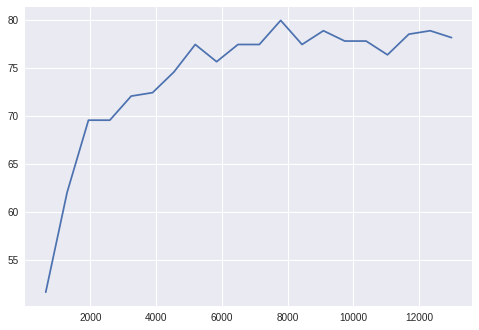

In [13]:
plt.plot(log['accuracy_step'], log['accuracy'])

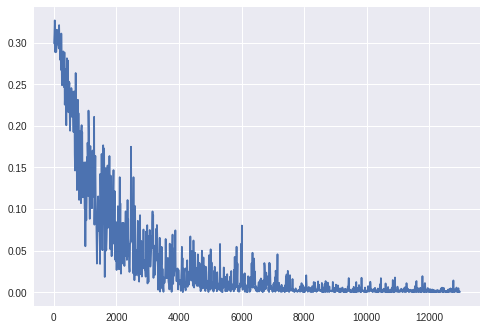

In [14]:
plt.plot(log['loss_step'], log['loss'])